# 自动化特征工程 - 使用模型选择特征

<p style="text-indent: 2em; font-family: 微软雅黑; FONT-SIZE: 100%; COLOR: #191919; line-height: 1.5em;">
此文档是根据IBM 实验室在自动化特征工程领域的研究"One button machine for automating feature engineering in relational databases"及相关文献的思路对开放数据集“Berka dataset”进行特征工程的初步实践。
</p>
<p style="text-indent: 2em; font-family: 微软雅黑; FONT-SIZE: 100%; COLOR: #191919; line-height: 1.5em;">
此部分是根据模型的特征贡献度来筛选生成的特征。
</p>

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import os

In [2]:
spark = SparkSession \
    .builder \
    .appName("Feature Engineering Prepare example") \
    .config("spark.sql.execution.arrow.enabled", "false") \
    .getOrCreate()

## 1. 读入特征宽表

In [3]:
path = os.environ['DSX_PROJECT_DIR']+'/datasets'

In [4]:
sch_loan_ex = StructType([
	StructField("account_id", IntegerType(), True),
	StructField("frequency", IntegerType(), True),
	StructField("acc_open_days", IntegerType(), True),
	StructField("gender", IntegerType(), True),
	StructField("birth_days", IntegerType(), True),
	StructField("client_cnt", IntegerType(), True),
	StructField("trans_cnt", IntegerType(), True),
	StructField("amt_s", DecimalType(11, 2), True),
	StructField("amt_a", DecimalType(11, 2), True),
	StructField("amt_d", DecimalType(11, 2), True),
	StructField("amt_x", DecimalType(11, 2), True),
	StructField("amt_n", DecimalType(11, 2), True),
	StructField("balance_s", DecimalType(11, 2), True),
	StructField("balance_a", DecimalType(11, 2), True),
	StructField("balance_d", DecimalType(11, 2), True),
	StructField("balance_x", DecimalType(11, 2), True),
	StructField("balance_n", DecimalType(11, 2), True),
	StructField("trans_dt_r", IntegerType(), True),
	StructField("symbol_1", IntegerType(), True),
	StructField("symbol_2", IntegerType(), True),
	StructField("symbol_3", IntegerType(), True),
	StructField("symbol_4", IntegerType(), True),
	StructField("symbol_5", IntegerType(), True),
	StructField("symbol_6", IntegerType(), True),
	StructField("symbol_amt_1_s", DecimalType(11, 2), True),
	StructField("symbol_amt_2_s", DecimalType(11, 2), True),
	StructField("symbol_amt_3_s", DecimalType(11, 2), True),
	StructField("symbol_amt_4_s", DecimalType(11, 2), True),
	StructField("symbol_amt_5_s", DecimalType(11, 2), True),
	StructField("symbol_amt_6_s", DecimalType(11, 2), True),
	StructField("symbol_amt_1_a", DecimalType(11, 2), True),
	StructField("symbol_amt_2_a", DecimalType(11, 2), True),
	StructField("symbol_amt_3_a", DecimalType(11, 2), True),
	StructField("symbol_amt_4_a", DecimalType(11, 2), True),
	StructField("symbol_amt_5_a", DecimalType(11, 2), True),
	StructField("symbol_amt_6_a", DecimalType(11, 2), True),
	StructField("symbol_amt_1_x", DecimalType(11, 2), True),
	StructField("symbol_amt_2_x", DecimalType(11, 2), True),
	StructField("symbol_amt_3_x", DecimalType(11, 2), True),
	StructField("symbol_amt_4_x", DecimalType(11, 2), True),
	StructField("symbol_amt_5_x", DecimalType(11, 2), True),
	StructField("symbol_amt_6_x", DecimalType(11, 2), True),
	StructField("symbol_amt_1_n", DecimalType(11, 2), True),
	StructField("symbol_amt_2_n", DecimalType(11, 2), True),
	StructField("symbol_amt_3_n", DecimalType(11, 2), True),
	StructField("symbol_amt_4_n", DecimalType(11, 2), True),
	StructField("symbol_amt_5_n", DecimalType(11, 2), True),
	StructField("symbol_amt_6_n", DecimalType(11, 2), True),
	StructField("card_cnt", IntegerType(), True),
	StructField("card_tp", IntegerType(), True),
	StructField("card_issued_days", IntegerType(), True),
	StructField("region_tp", IntegerType(), True),
	StructField("Inhabitants", IntegerType(), True),
	StructField("Municipalities499", IntegerType(), True),
	StructField("Municipalities1999", IntegerType(), True),
	StructField("Municipalities9999", IntegerType(), True),
	StructField("Municipalities10000", IntegerType(), True),
	StructField("cities", IntegerType(), True),
	StructField("urbanratio", DecimalType(11, 2), True),
	StructField("avgsalary", DecimalType(11, 2), True),
	StructField("unemploy95", DecimalType(11, 2), True),
	StructField("unemploy96", DecimalType(11, 2), True),
	StructField("Enterpreneurs", IntegerType(), True),
	StructField("crimes95", IntegerType(), True),
	StructField("crimes96", IntegerType(), True),
	StructField("payorder_cnt", IntegerType(), True),
	StructField("payorder_amt_s", DecimalType(11, 2), True),
	StructField("payorder_amt_a", DecimalType(11, 2), True),
	StructField("payorder_amt_t", DecimalType(11, 2), True),
	StructField("payorder_amt_x", DecimalType(11, 2), True),
	StructField("payorder_symbol_1", IntegerType(), True),
	StructField("payorder_symbol_2", IntegerType(), True),
	StructField("payorder_symbol_3", IntegerType(), True),
	StructField("payorder_symbol_4", IntegerType(), True),
	StructField("payorder_symbol_6", IntegerType(), True),
	StructField("granted_days", IntegerType(), True),
	StructField("amount", DecimalType(11, 2), True),
	StructField("duration", IntegerType(), True),
	StructField("payments", DecimalType(11, 2), True),
	StructField("label", IntegerType(), True)
    ])

In [5]:
df_loan = spark.read.csv(path+"/loan_ex2.csv", header=True, schema=sch_loan_ex)

In [6]:
df_loan.show(2)

+----------+---------+-------------+------+----------+----------+---------+----------+-------+-------+--------+-----+-----------+---------+---------+---------+---------+----------+--------+--------+--------+--------+--------+--------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------+-------+----------------+---------+-----------+-----------------+------------------+------------------+-------------------+------+----------+---------+----------+----------+-------------+--------+--------+------------+--------------+--------------+--------------+--------------+-----------------+-----------------+-----------------+-----------------+-----------------+------------+---------+------

In [7]:
cols =["frequency", "acc_open_days", "gender", "birth_days", "client_cnt", "trans_cnt", \
               "amt_s", "amt_a", "amt_d", "amt_x", "amt_n", "balance_s", "balance_a", "balance_d", \
               "balance_x", "balance_n", "trans_dt_r", "symbol_1", "symbol_2", "symbol_3", "symbol_4",  "symbol_5", \
               "symbol_6", "symbol_amt_1_s", "symbol_amt_2_s", "symbol_amt_3_s", "symbol_amt_4_s", \
               "symbol_amt_5_s", "symbol_amt_6_s", "symbol_amt_1_a", "symbol_amt_2_a", "symbol_amt_3_a", "symbol_amt_4_a", \
               "symbol_amt_5_a", "symbol_amt_6_a", "symbol_amt_1_x", "symbol_amt_2_x", "symbol_amt_3_x", "symbol_amt_4_x", \
               "symbol_amt_5_x", "symbol_amt_6_x", "symbol_amt_1_n", "symbol_amt_2_n", "symbol_amt_3_n", "symbol_amt_4_n", \
               "symbol_amt_5_n", "symbol_amt_6_n", "card_cnt", "card_tp", "card_issued_days", "region_tp", "Inhabitants", \
               "Municipalities499", "Municipalities1999", "Municipalities9999", "Municipalities10000", \
               "cities", "urbanratio", "avgsalary", "unemploy95", "unemploy96", "Enterpreneurs", "crimes95", \
               "crimes96", "payorder_cnt", "payorder_amt_s", "payorder_amt_a", "payorder_amt_t", \
               "payorder_amt_x", "payorder_symbol_1", "payorder_symbol_2", "payorder_symbol_3", \
               "payorder_symbol_4", "payorder_symbol_6", "granted_days", "amount", "duration", "payments"]

## 2. 建模并训练

### 2.1 组装特征

<p style="text-indent: 2em; font-family: 微软雅黑; FONT-SIZE: 100%; COLOR: #191919; line-height: 1.5em;">
使用Spark pipeline方式。pipeline第一阶段是组装特征。
</p>


In [8]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
# ["frequency", "acc_open_days", "gender", "birth_days", "client_cnt", "trans_cnt", "amt_s", "amt_a", "amt_d", "amt_x", "amt_n", "balance_s", "balance_a", "balance_d", "balance_x", "balance_n", "trans_dt_r", "symbol_1", "symbol_2", "symbol_3", "symbol_4", "symbol_6", "symbol_amt_1_s", "symbol_amt_2_s", "symbol_amt_3_s", "symbol_amt_4_s", "symbol_amt_6_s", "symbol_amt_1_x", "symbol_amt_2_x", "symbol_amt_3_x", "symbol_amt_4_x", "symbol_amt_6_x", "symbol_amt_1_n", "symbol_amt_2_n", "symbol_amt_3_n", "symbol_amt_4_n", "symbol_amt_6_n", "card_cnt", "card_tp", "card_issued_days", "region_tp", "Inhabitants", "Municipalities499", "Municipalities1999", "Municipalities9999", "Municipalities10000", "cities", "urbanratio", "avgsalary", "unemploy95", "unemploy96", "Enterpreneurs", "crimes95", "crimes96", "payorder_cnt", "payorder_amt_s", "payorder_amt_a", "payorder_amt_t", "payorder_amt_x", "payorder_symbol_1", "payorder_symbol_2", "payorder_symbol_3", "payorder_symbol_4", "payorder_symbol_6", "granted_days", "amount", "duration", "payments"]
assembler = VectorAssembler(
    inputCols=cols,
    outputCol="features")

output = assembler.transform(df_loan)
output.select("features", "label").show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[1.0,487.0,2.0,12...|    0|
|[1.0,1388.0,2.0,1...|    0|
|[1.0,983.0,2.0,18...|    0|
|[2.0,689.0,2.0,83...|    0|
|[1.0,539.0,1.0,84...|    0|
+--------------------+-----+
only showing top 5 rows



### 2.2 使用随机森林分类算法

In [9]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(numTrees=95, maxDepth=5, maxBins=180, labelCol="label", seed=207336481)


### 2.3 对结果进行转换

In [10]:
from pyspark.ml.feature import IndexToString
from pyspark.ml import Model, Pipeline
labelConverter = IndexToString(inputCol="prediction", 
                               outputCol="predictedLabel", labels=['not default', 'default'])

### 2.4 组装为pipeline

In [11]:
pipeline_rf = Pipeline(stages=[assembler, rf, labelConverter])

### 2.5 分拆训练集

In [12]:
splitted_data = df_loan.randomSplit([0.7, 0.30], 24)
train_data = splitted_data[0]
test_data = splitted_data[1]
#predict_data = splitted_data[2]

print("Number of training records: " + str(train_data.count()))
print("Number of testing records : " + str(test_data.count()))

Number of training records: 465
Number of testing records : 209


### 2.6 超参数优化
<p style="text-indent: 2em; font-family: 微软雅黑; FONT-SIZE: 100%; COLOR: #191919; line-height: 1.5em;">
由于训练数据量较小，采用交叉校验方式，参数定位3折。优化采用网格搜索方式。
</p>
<p style="text-indent: 2em; font-family: 微软雅黑; FONT-SIZE: 100%; COLOR: #191919; line-height: 1.5em;">
对于优化的参数：
<ul>
    <li>maxDepth:&nbsp;&nbsp;表示算法复杂度</li>
    <li>maxBins:&nbsp;&nbsp;在对连续变量离散化时的参数</li>
    <li>numTrees:&nbsp;&nbsp;影响整体方差的参数</li>
</ul>
</p>


In [13]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

paramGrid = ParamGridBuilder() \
    .addGrid(rf.maxDepth, [5, 6, 7]) \
    .addGrid(rf.maxBins, [120, 180]) \
    .addGrid(rf.numTrees, [85, 90, 95]) \
    .build()

In [14]:
crossval = CrossValidator(estimator=pipeline_rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3)  # use 3+ folds in practice

# Run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit(train_data)

In [31]:
#model_rf = pipeline_rf.fit(train_data)

### 2.7 计算模型性能

In [32]:
#rf_tr = model_rf.transform(train_data)
rf_tr = cvModel.bestModel.transform(train_data)


In [34]:
#rf_te = model_rf.transform(test_data)
rf_te = cvModel.bestModel.transform(test_data)


In [35]:
from  pyspark.mllib.evaluation import BinaryClassificationMetrics

def calcuAUC(rf_data):
    s_l = rf_data.rdd.map(lambda x: [float(x.probability[1]), float(x.label)]).collect()
    s_l = sc.parallelize(s_l)
    metrics = BinaryClassificationMetrics(s_l)
    print("areaUnderROC: " + str(metrics.areaUnderROC))
    print("areaUnderPR: " + str(metrics.areaUnderPR))

In [36]:
calcuAUC(rf_tr)

areaUnderROC: 1.0
areaUnderPR: 1.0


In [37]:
calcuAUC(rf_te)

areaUnderROC: 0.9997662459093034
areaUnderPR: 0.9981490233144298


In [38]:
from  pyspark.mllib.evaluation import MulticlassMetrics
def calcuMetrics(rf_data):
    predictionAndLabels = rf_data.rdd.map(lambda x: [float(x.prediction), float(x.label)]).collect()
    predictionAndLabels = sc.parallelize(predictionAndLabels)
    mmetrics = MulticlassMetrics(predictionAndLabels)
    print("Accuracy: ", mmetrics.accuracy)
    print("Precision for default: ", mmetrics.precision(1.0))
    print("Recall for default: ", mmetrics.recall(1.0))
    print("Precision for not default: ", mmetrics.precision(0.0))
    print("Recall for not default: ", mmetrics.recall(0.0))
    print("TruePositiveRate for default: ", mmetrics.truePositiveRate(1.0))
    print("FalsePositiveRate for default: ", mmetrics.falsePositiveRate(1.0))
    print("TruePositiveRate for not default: ", mmetrics.truePositiveRate(0.0))
    print("FalsePositiveRate for not default: ", mmetrics.falsePositiveRate(0.0))
    print("ConfusionMatrix: ", mmetrics.confusionMatrix())

In [39]:
calcuMetrics(rf_tr)

Accuracy:  1.0
Precision for default:  1.0
Recall for default:  1.0
Precision for not default:  1.0
Recall for not default:  1.0
TruePositiveRate for default:  1.0
FalsePositiveRate for default:  0.0
TruePositiveRate for not default:  1.0
FalsePositiveRate for not default:  0.0
ConfusionMatrix:  DenseMatrix([[414.,   0.],
             [  0.,  51.]])


In [40]:
calcuMetrics(rf_te)

Accuracy:  0.9952153110047847
Precision for default:  1.0
Recall for default:  0.9565217391304348
Precision for not default:  0.9946524064171123
Recall for not default:  1.0
TruePositiveRate for default:  0.9565217391304348
FalsePositiveRate for default:  0.0
TruePositiveRate for not default:  1.0
FalsePositiveRate for not default:  0.043478260869565216
ConfusionMatrix:  DenseMatrix([[186.,   0.],
             [  1.,  22.]])


## 3. 根据贡献度给出特征排序

In [41]:
#rf_model = model_rf.stages[1]
rf_model = cvModel.bestModel.stages[1]

In [42]:
col_imps = list(zip(cols, rf_model.featureImportances))

In [43]:
col_imps.sort(key=lambda x: x[1], reverse=True)

In [45]:
for i in range(30):
    print(col_imps[i][0], "\t: ", col_imps[i][1])

balance_n 	:  0.37918140002627626
amt_n 	:  0.18137933031017298
balance_a 	:  0.061910344917902795
balance_d 	:  0.022454375059574566
symbol_amt_4_x 	:  0.019172597250709904
symbol_amt_6_a 	:  0.017849736979680335
payorder_symbol_2 	:  0.016957966956763354
amount 	:  0.014546909282150704
balance_s 	:  0.014399785337960233
payments 	:  0.013955134300917892
symbol_amt_6_s 	:  0.01274706399029782
payorder_amt_t 	:  0.011808340870966834
balance_x 	:  0.011650519952189048
amt_x 	:  0.01087497086702455
symbol_amt_5_a 	:  0.010571224350669565
symbol_amt_5_x 	:  0.01040935159765619
payorder_cnt 	:  0.008064792139447191
payorder_amt_x 	:  0.007359559486660854
symbol_5 	:  0.0072300702812835285
symbol_6 	:  0.006787245174304823
payorder_amt_s 	:  0.00677487838822423
symbol_amt_2_s 	:  0.006532600245316338
granted_days 	:  0.006514565104088321
symbol_amt_4_a 	:  0.005890350253610058
Municipalities499 	:  0.005841986374233306
birth_days 	:  0.005670350908004508
symbol_amt_2_x 	:  0.005356376581897

In [46]:
keys = [t[0] for t in col_imps]
imps = [t[1] for t in col_imps]

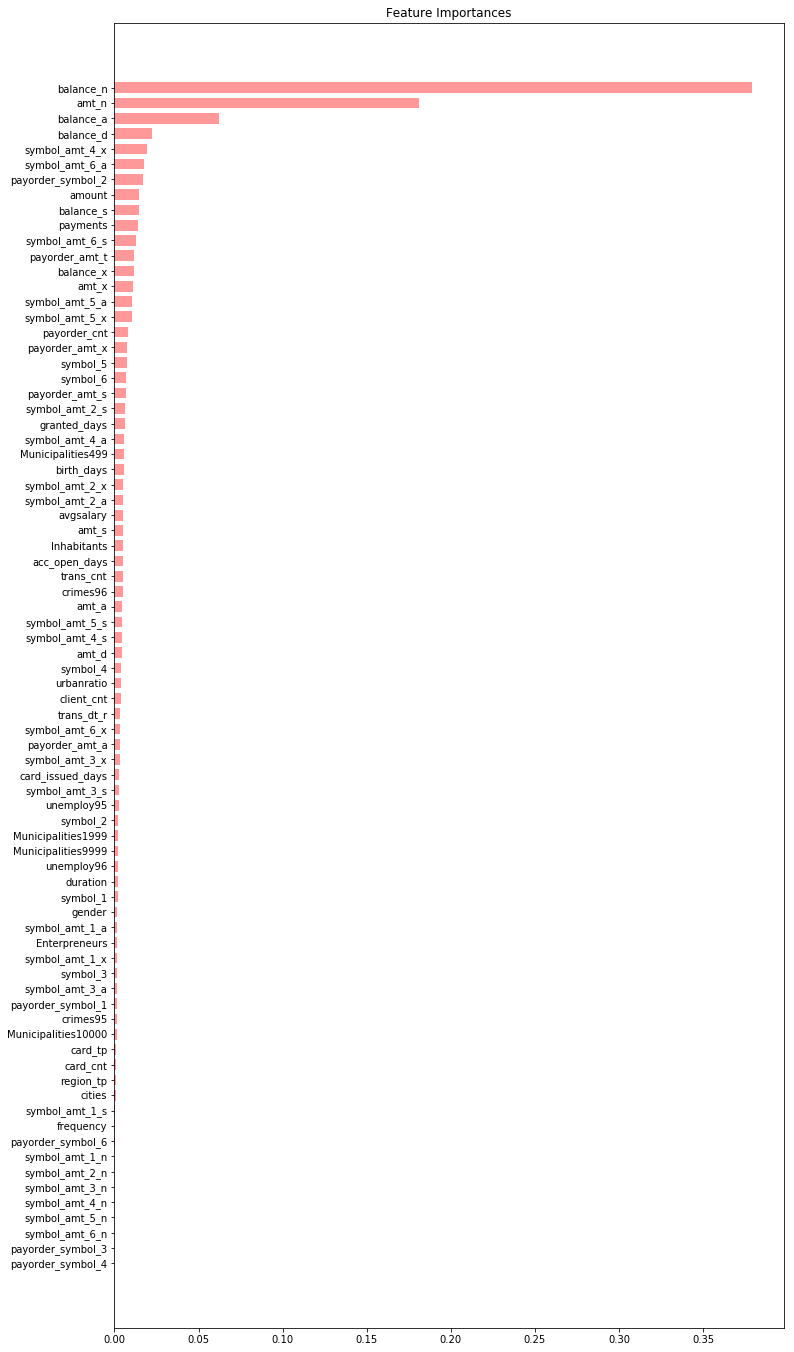

In [48]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

plt.figure(figsize = (12, 24))
ax = plt.subplot()
ax.barh(list(reversed(range(len(keys)))), imps, 0.7,  alpha=0.4, color='r')
ax.set_yticks(list(reversed(range(len(keys)))))
ax.set_yticklabels(keys)
    
plt.title('Feature Importances')
plt.show()

In [49]:
spark.stop()

## 作者

**李英伟 liyingw@cn.ibm.com ** 